In [1]:
import requests
import json
from pathlib import Path
import glob
import time
from pprint import pprint as pp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

In [2]:
def num_files(tier_code):
    files = glob.glob('../data/match_info/%d*.json'%tier_code)
    print(f"There exist {len(files):>5} files for tier_code {tier_code}")

In [3]:
def summoner_in_match(path):
    file = Path(path).read_bytes()
    file_dic = json.loads(file.decode())
    summoner_list = [f['player']['summonerName'] for f in file_dic['participantIdentities']]
    return summoner_list

In [4]:
def is_summoner(path, summoner_name, lane):
    file = Path(path).read_bytes()
    file_dic = json.loads(file.decode())
    summoner_list = [f['player']['summonerName'] for f in file_dic['participantIdentities']]
    pId = None
    try:
        pId = summoner_list.index(summoner_name)
    except ValueError:
        return False
    return (lane == None) or (file_dic['participants'][pId]['timeline']['lane'] == lane)

In [5]:
def match_by_summoner(summoner_name, lane = None):
    matches = []
    for tier in range(1,6):
        print(f"Searching Tier Code {tier}")
        num_matches = len(matches)
        files = glob.glob(f'../data/match_info/{tier}*.json')
        for file in files:
            if is_summoner(file, summoner_name, lane):
                matches.append(file)
        if(num_matches != len(matches)):
            break
    return matches

In [6]:
def generate_sumlist():
    summoners = {}
    files = glob.glob('../data/match_info/*')
    files_num = len(files)
    count = 0
    start_time = time.time()
    for file in files:
        count = count + 1
        sum_list = summoner_in_match(file)
        for summonor in sum_list:
            if(summonor not in summoners):
                summoners[summonor] = 1
            else:
                summoners[summonor] = summoners[summonor] + 1
        print(f'{count}/{files_num}', end = '\r')
    print(time.time()-start_time)
    return summoners

In [7]:
def pts_extracter(match_id, summoner_name):
    timeline_path = f'../data/match_timeline/{match_id}.json'
    info_path = f'../data/match_info/{match_id}.json'
    tl = Path(timeline_path).read_bytes()
    tl_dic = json.loads(tl.decode())
    info = Path(info_path).read_bytes()
    info_dic = json.loads(info.decode())
    
    ingameId = 0
    for parts in info_dic['participantIdentities']:
        if(parts['player']['summonerName'] == summoner_name):
            ingameId = parts['participantId']
            break
    x = []
    y = []
    count = 0
    for frame in tl_dic['frames']:
        if count > 10:
            break
        try:
            x.append(frame['participantFrames'][str(ingameId)]['position']['x'])
            y.append(frame['participantFrames'][str(ingameId)]['position']['y'])
            for event in frame['events']:
                if (event['type'] == 'CHAMPION_KILL'):
                    if((event['killerId'] == ingameId) or (event['victimId'] == ingameId) or (ingameId in event['assistingParticipantIds'])):
                        x.append(event['position']['x'])
                        y.append(event['position']['y'])
        except:
            pass
        count += 1
    return x,y

In [8]:
def jg_pts_extracter(match_id, summoner_name):
    timeline_path = f'../data/match_timeline/{match_id}.json'
    info_path = f'../data/match_info/{match_id}.json'
    tl = Path(timeline_path).read_bytes()
    tl_dic = json.loads(tl.decode())
    info = Path(info_path).read_bytes()
    info_dic = json.loads(info.decode())
    
    ingameId = 0
    team = None
    for pId, parts in enumerate(info_dic['participants']):
        if((parts['spell1Id'] == 11 or parts['spell2Id'] == 11) and info_dic['participantIdentities'][pId]['player']['summonerName'] == summoner_name):
            ingameId = pId + 1
            team = 'blue' if parts['teamId'] == 100 else 'red'
            #print(f"{parts['spell1Id'] == 11 or parts['spell2Id'] == 11}/{info_dic['participantIdentities'][pId]['player']['summonerName']}")
            break
            
    x = []
    y = []
    count = 0
    if ingameId != 0:
        for frame in tl_dic['frames']:
            if count > 10:
                break
            if count != 0:
                tmp_x = []
                tmp_y = []
                try:
                    tmp_x.append(frame['participantFrames'][str(ingameId)]['position']['x'])
                    tmp_y.append(frame['participantFrames'][str(ingameId)]['position']['y'])
                    for event in frame['events']:
                        if (event['type'] == 'CHAMPION_KILL'):
                            if((event['killerId'] == ingameId) or (event['victimId'] == ingameId) or (ingameId in event['assistingParticipantIds'])):
                                tmp_x.append(event['position']['x'])
                                tmp_y.append(event['position']['y'])
                except:
                    pass
                x.append(tmp_x)
                y.append(tmp_y)
            count += 1
    return x, y, team

In [9]:
def heatmap(x, y, s, bins):
    heatmap, xedge, yedge = np.histogram2d(x, y, range = [[0, 15000], [0, 15000]], bins=bins)    
    heatmap = gaussian_filter(heatmap, sigma=s)
    return heatmap.T

def show_heat_scatter(pts_dict,s, bins = 500, markersize = 2):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    fig = plt.figure(figsize=(5,10))
    extent = [0,15000,0,15000]
    
    axs[0].plot(pts_dict['blue']['x'], pts_dict['blue']['y'], 'b.', markersize=markersize)
    axs[0].set_xlim([0, 15000])
    axs[0].set_ylim([0, 15000])
    axs[0].set_title("Blue team Scatter plot")
    img = plt.imread("./Minimap.png")
    axs[0].imshow(img, zorder=0, extent=extent)

    heat_blue = heatmap(pts_dict['blue']['x'], pts_dict['blue']['y'], s, bins)
    axs[1].imshow(heat_blue, extent = extent, origin='lower', cmap=cm.jet)
    axs[1].set_title("Blue team, Smoothing with  $\sigma$ = %d" % s)
    
    axs[2].plot(pts_dict['red']['x'], pts_dict['red']['y'], 'b.', markersize=markersize)
    axs[2].set_xlim([0, 15000])
    axs[2].set_ylim([0, 15000])
    axs[2].set_title("Red team Scatter plot")
    img = plt.imread("./Minimap.png")
    axs[2].imshow(img, zorder=0, extent=extent)
    
    heat_red = heatmap(pts_dict['red']['x'], pts_dict['red']['y'], s, bins)
    axs[3].imshow(heat_red, extent = extent, origin='lower', cmap=cm.jet)
    axs[3].set_title("red team, Smoothing with  $\sigma$ = %d" % s)
    plt.show()

In [10]:
def sort_pts_by_time(pts_list):
    pts = []
    frames = 10
    for timelen in range(frames):
        pts.append([])
        for match_num in range((int)(len(pts_list)/frames)):
            pts[timelen] += pts_list[match_num*10 + timelen]
    return pts

In [11]:
def is_Top(x,y):
    return (x < 4000 and y > 10000) and (np.linalg.norm([x-4000,y-10000]) > 2000)
def is_Bottom(x,y):
    return (y < 4000 and x > 10000) and (np.linalg.norm([x-10000,y-4000]) > 2000)
def is_Mid(x,y):
    return np.linalg.norm(([x-7500,y-7500]), ord=1) < 1500

In [12]:
for i in range(1,6):
    num_files(i)

There exist  2399 files for tier_code 1
There exist  2400 files for tier_code 2
There exist  2400 files for tier_code 3
There exist  2465 files for tier_code 4
There exist  1200 files for tier_code 5


In [13]:
files = glob.glob('../data/match_info/*.json')
summoner_dict = {}
start_time = time.time()
for file in files:
    summoners = summoner_in_match(file)
    for summoner in summoners:
        if summoner in summoner_dict:
            summoner_dict[summoner] += 1
        else:
            summoner_dict[summoner] = 1
print(time.time()-start_time)

KeyboardInterrupt: 

In [110]:
major_summoners = [key for key in summoner_dict if summoner_dict[key] > 90]

In [111]:
major_summoners

['유이가하마 유이',
 '갓차녁임',
 '멀 탯',
 '태조아들이방원',
 '전상필',
 'IIIlIIlIIIIlIIll',
 '강 xin he',
 '채널A',
 '스트렛',
 'Owned u',
 '요크셔김태리어',
 '켑 틴 잭',
 'Kim Give Smart',
 'osl',
 '이제학식먹을나이',
 '정글몹왜쳐먹냐',
 'Ezreal',
 'Nasus',
 'Ryze',
 'Alistar',
 'Galio',
 '프레이는돼지',
 'Shaco M1',
 '편명장사타구니',
 '핑와안까는서폿터',
 '잘난사람',
 '구국구구구구규',
 '우쥬체강ZI존베인',
 'Hide on bubal',
 '귤 먹는 할배',
 'Distancia',
 'hen xihuan',
 'Temp2st',
 'Dor0thy',
 'Fast Climber',
 '탑 감수성 노터치',
 '손삼입오',
 '지금왔다고요',
 '민 뀰',
 '알아서멎하게',
 '아내일개학임',
 '취미가없는사람',
 'Xin zan bi',
 '소옹씨임',
 '단 폴',
 'Wuhu',
 '진다는건뭘까',
 '오엉주',
 '맛없잖아',
 '똥딸기배',
 'Gold Card',
 '일산패드리퍼',
 '향로빌드',
 '달님맛초코송이',
 '김꼬chi',
 '손 주연잉1',
 'I hate Sup',
 '채팅안치는 칸',
 '구포중',
 '홍진호가 간다',
 '밀양동씨',
 '수호짜응',
 'Naviestoke',
 '요네3041',
 'LittleRookey',
 'sungs',
 '강유미님',
 '정글갱안간다고',
 '리동망의 개',
 'ChoVySang1',
 '재희S',
 '아니핑계속찍어줬자나왜안빼냐고',
 '모질유민',
 'Bottom Dogg',
 '별수호자 이성은',
 'time4x',
 'ForkFeeling',
 '리신 제드',
 '요정도 햿음 주자',
 'wpdnckd2',
 '윤여은아',
 'RPG장in',
 '집이안보여요',
 '크림빵여신',
 'Got ist tot',
 '슬기로

In [73]:
for idx, target_summoner in enumerate(major_summoners):
    mts = match_by_summoner(target_summoner)
    print(f'There exist {len(mts)} matches')

    pts = {'blue' : {'x' : [], 'y' : []}, 'red' : {'x' : [], 'y' : []}}
    blue_jg_count = 0
    red_jg_count = 0
    for index in range(len(mts)):
        tmp_x, tmp_y, team = jg_pts_extracter(mts[index][19:-5], target_summoner)
        if team == None:
            continue
        pts[team]['x'] += [y for x in tmp_x for y in x]
        pts[team]['y'] += [y for x in tmp_y for y in x]
        if team == 'blue':
            blue_jg_count += 1
        else:
            red_jg_count += 1
    print(f"idx : {idx}, summoner name : {target_summoner}, {blue_jg_count} blue, {red_jg_count} red, total {blue_jg_count+red_jg_count} matches!")
    if blue_jg_count+red_jg_count != 0:
        show_heat_scatter(pts,20,1000)
    else:
        print("Not Jungle User")

NameError: name 'major_summoners' is not defined

In [170]:
t_mts = match_by_summoner(major_summoners[0], 'JUNGLE')

Searching Tier Code 1


In [13]:
import pathlib
def save_match(match_id, tier_code):
    timeline_file = Path(f'../data/match_timeline/{tier_code}_{match_id}.json')
    info_file = Path(f'../data/match_info/{tier_code}_{match_id}.json')
    if timeline_file.is_file() and info_file.is_file():
        print('Match data already exist', end = '\r')
    else:  
        tl_request = f"https://kr.api.riotgames.com/lol/match/v4/timelines/by-match/{match_id}?api_key={api_key}"
        info_request = f"https://kr.api.riotgames.com/lol/match/v4/matches/{match_id}?api_key={api_key}"

        tl = requests.get(tl_request)
        mts = requests.get(info_request)
        
        count = 0
        while ('status' in mts.json()) or ('status' in tl.json()):
            for _ in range(10):
                print(f"Waiting {count+1}", end = "\r")
                count = count + 1
                time.sleep(1)
            tl = requests.get(tl_request)
            mts = requests.get(info_request)
        
        pathlib.Path(f'../data/match_timeline/{tier_code}_{match_id}.json').write_bytes(tl.content)
        pathlib.Path(f'../data/match_info/{tier_code}_{match_id}.json').write_bytes(mts.content)
        print(f"{match_id} Saved", end = '\r')

In [55]:
api_key = 'RGAPI-db0ce53a-e679-4a4a-aca0-8dd9f5785755'

summoner_name = "PL천년나무네"
tier_code = 4
sum_req = requests.get(f"https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/{summoner_name}?api_key={api_key}")
sum_info = sum_req.json()
mat_list_req =requests.get(f"https://kr.api.riotgames.com/lol/match/v4/matchlists/by-account/{sum_info['accountId']}?api_key={api_key}")
mat_req = mat_list_req.json()
mat_list = [match['gameId'] for match in mat_req['matches']]

mts = [f'../data/match_info\\{tier_code}_{mat}.json' for mat in mat_list]

In [56]:
for mat in mat_list:
    save_match(mat, tier_code)

In [57]:
pts = {'blue' : {'x' : [], 'y' : []}, 'red' : {'x' : [], 'y' : []}}
blue_jg_count = 0
red_jg_count = 0
for index in range(len(mts)):
    tmp_x, tmp_y, team = jg_pts_extracter(mts[index][19:-5], summoner_name)
    if team == None:
        continue
    pts[team]['x'] += tmp_x
    pts[team]['y'] += tmp_y
    if team == 'blue':
        blue_jg_count += 1
    else:
        red_jg_count += 1
print(f"{red_jg_count+blue_jg_count} matches ({blue_jg_count} blue / {red_jg_count} red)")

10 matches (6 blue / 4 red)


In [58]:
b_x = sort_pts_by_time(pts['blue']['x'])
b_y = sort_pts_by_time(pts['blue']['y'])
r_x = sort_pts_by_time(pts['red']['x'])
r_y = sort_pts_by_time(pts['red']['y'])

1 minutes
As Blue team
top : 33.33%(2pts)         / mid : 0.00%(0pts)         / bot : 0.00%(0pts)         / other : 66.67%(4pts)         / total : 6pts
As Red team
top : 50.00%(2pts)         / mid : 0.00%(0pts)         / bot : 0.00%(0pts)         / other : 50.00%(2pts)         / total : 4pts


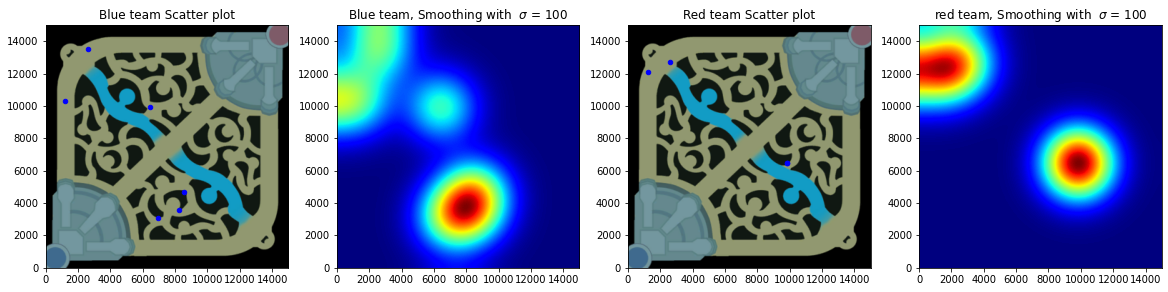

<Figure size 360x720 with 0 Axes>

2 minutes
As Blue team
top : 42.86%(3pts)         / mid : 0.00%(0pts)         / bot : 0.00%(0pts)         / other : 57.14%(4pts)         / total : 7pts
As Red team
top : 50.00%(2pts)         / mid : 0.00%(0pts)         / bot : 0.00%(0pts)         / other : 50.00%(2pts)         / total : 4pts


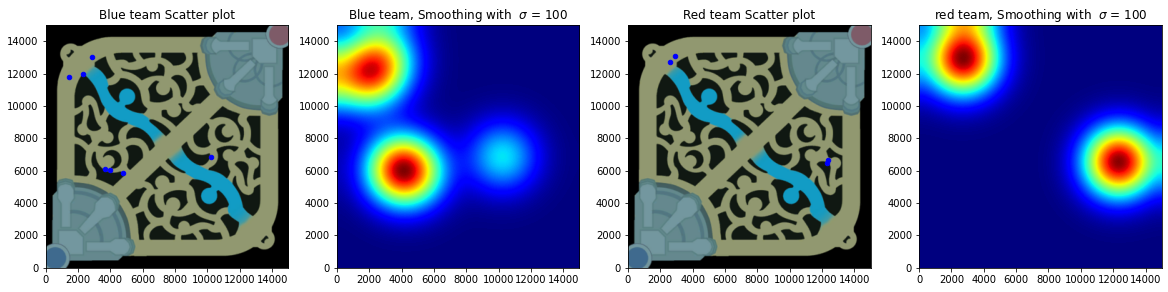

<Figure size 360x720 with 0 Axes>

3 minutes
As Blue team
top : 50.00%(3pts)         / mid : 0.00%(0pts)         / bot : 0.00%(0pts)         / other : 50.00%(3pts)         / total : 6pts
As Red team
top : 50.00%(2pts)         / mid : 0.00%(0pts)         / bot : 0.00%(0pts)         / other : 50.00%(2pts)         / total : 4pts


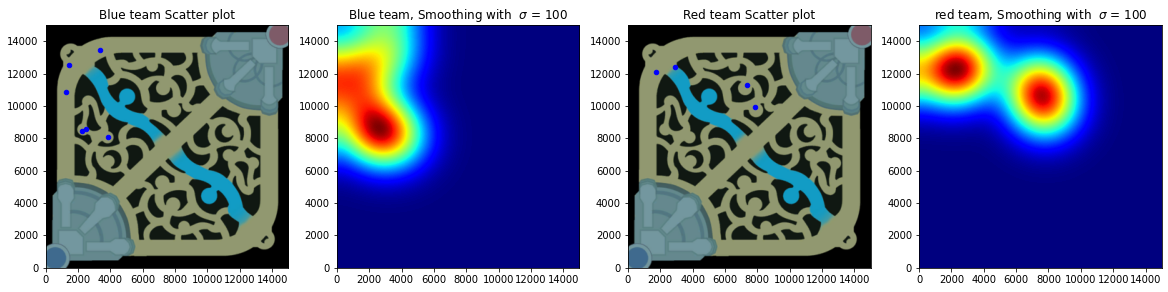

<Figure size 360x720 with 0 Axes>

4 minutes
As Blue team
top : 42.86%(3pts)         / mid : 0.00%(0pts)         / bot : 0.00%(0pts)         / other : 57.14%(4pts)         / total : 7pts
As Red team
top : 50.00%(2pts)         / mid : 0.00%(0pts)         / bot : 0.00%(0pts)         / other : 50.00%(2pts)         / total : 4pts


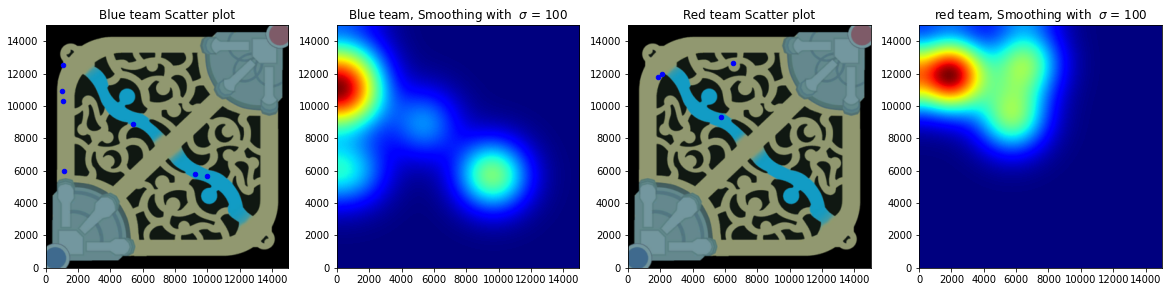

<Figure size 360x720 with 0 Axes>

5 minutes
As Blue team
top : 50.00%(3pts)         / mid : 0.00%(0pts)         / bot : 16.67%(1pts)         / other : 33.33%(2pts)         / total : 6pts
As Red team
top : 25.00%(1pts)         / mid : 0.00%(0pts)         / bot : 0.00%(0pts)         / other : 75.00%(3pts)         / total : 4pts


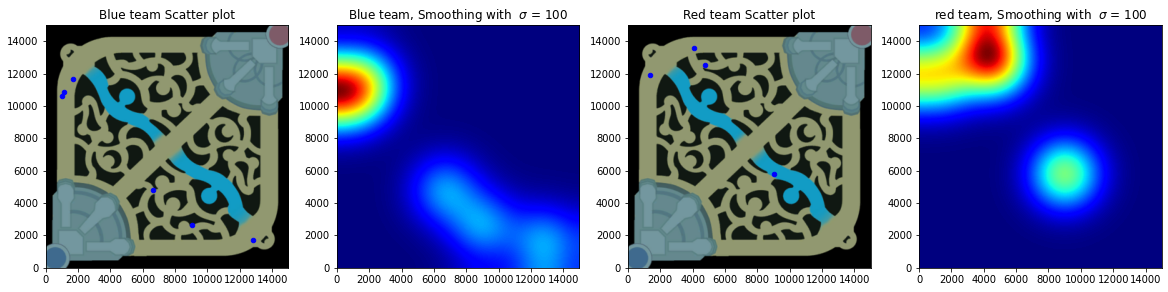

<Figure size 360x720 with 0 Axes>

6 minutes
As Blue team
top : 37.50%(3pts)         / mid : 0.00%(0pts)         / bot : 25.00%(2pts)         / other : 37.50%(3pts)         / total : 8pts
As Red team
top : 33.33%(2pts)         / mid : 16.67%(1pts)         / bot : 16.67%(1pts)         / other : 33.33%(2pts)         / total : 6pts


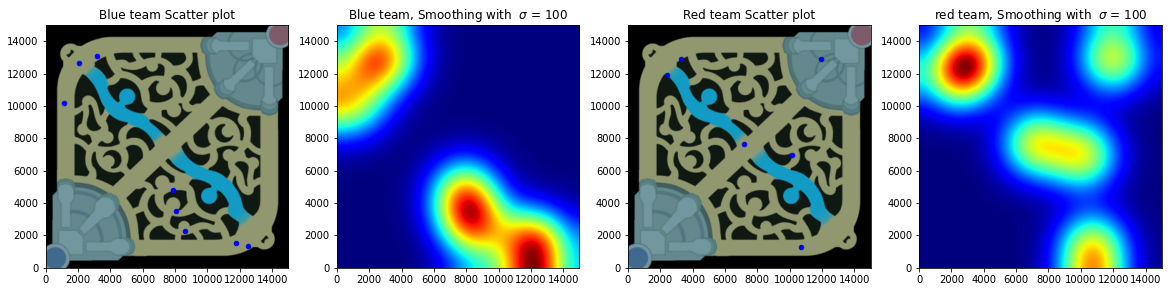

<Figure size 360x720 with 0 Axes>

7 minutes
As Blue team
top : 16.67%(1pts)         / mid : 0.00%(0pts)         / bot : 16.67%(1pts)         / other : 66.67%(4pts)         / total : 6pts
As Red team
top : 60.00%(3pts)         / mid : 0.00%(0pts)         / bot : 20.00%(1pts)         / other : 20.00%(1pts)         / total : 5pts


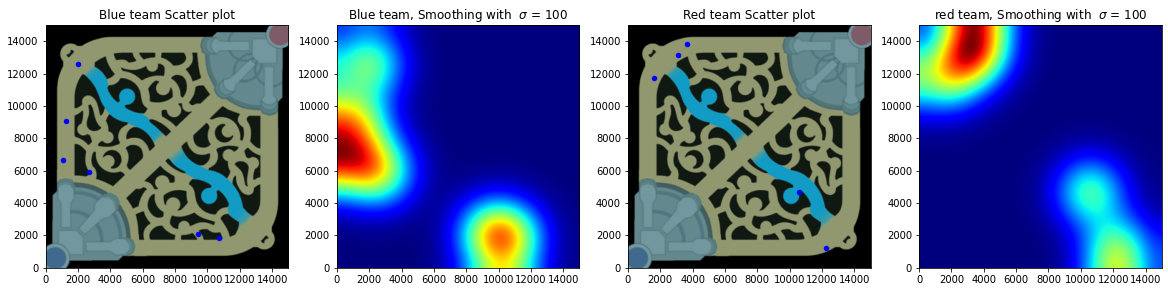

<Figure size 360x720 with 0 Axes>

8 minutes
As Blue team
top : 33.33%(3pts)         / mid : 0.00%(0pts)         / bot : 0.00%(0pts)         / other : 66.67%(6pts)         / total : 9pts
As Red team
top : 40.00%(2pts)         / mid : 0.00%(0pts)         / bot : 0.00%(0pts)         / other : 60.00%(3pts)         / total : 5pts


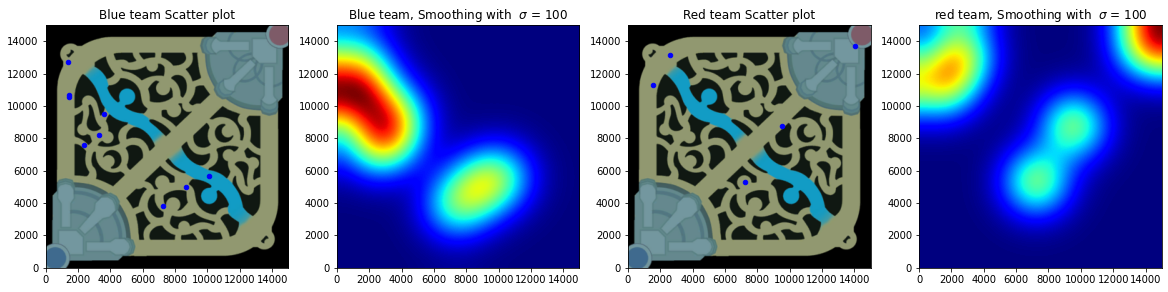

<Figure size 360x720 with 0 Axes>

9 minutes
As Blue team
top : 33.33%(2pts)         / mid : 0.00%(0pts)         / bot : 0.00%(0pts)         / other : 66.67%(4pts)         / total : 6pts
As Red team
top : 28.57%(2pts)         / mid : 14.29%(1pts)         / bot : 0.00%(0pts)         / other : 57.14%(4pts)         / total : 7pts


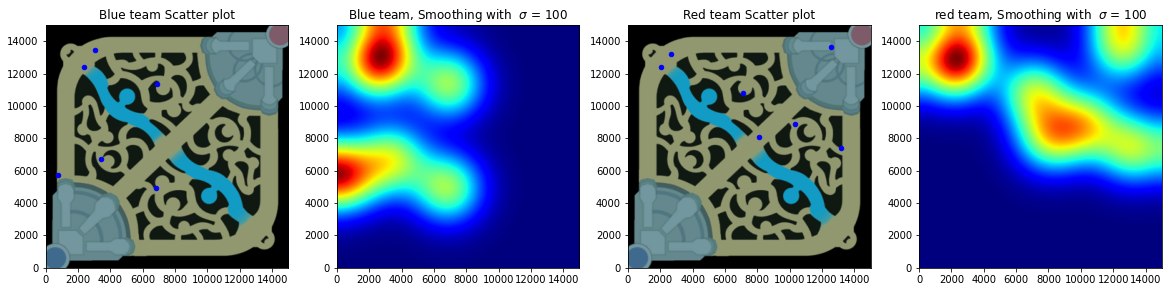

<Figure size 360x720 with 0 Axes>

10 minutes
As Blue team
top : 20.00%(2pts)         / mid : 10.00%(1pts)         / bot : 20.00%(2pts)         / other : 50.00%(5pts)         / total : 10pts
As Red team
top : 20.00%(1pts)         / mid : 20.00%(1pts)         / bot : 0.00%(0pts)         / other : 60.00%(3pts)         / total : 5pts


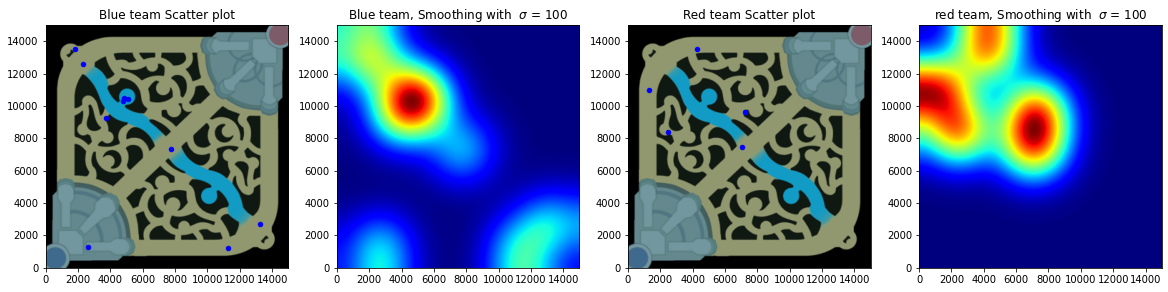

<Figure size 360x720 with 0 Axes>

In [59]:
pts_log = {'blue' : {'top' : [], 'mid' : [], 'bot': [], 'other' : [], 'total' : []},
           'red' : {'top' : [], 'mid' : [], 'bot': [], 'other' : [], 'total' : []}}
for frame in range(10):
    print(f'{frame+1} minutes')
    top_pts = sum(map(is_Top, b_x[frame], b_y[frame]))
    mid_pts = sum(map(is_Mid, b_x[frame], b_y[frame]))
    bot_pts = sum(map(is_Bottom, b_x[frame], b_y[frame]))
    total_pts = len(b_x[frame])
    other_pts = total_pts-top_pts-mid_pts-bot_pts
    pts_log['blue']['top'].append(top_pts)
    pts_log['blue']['mid'].append(mid_pts)
    pts_log['blue']['bot'].append(bot_pts)
    pts_log['blue']['other'].append(other_pts)
    pts_log['blue']['total'].append(total_pts)
    if total_pts == 0:
        print('No Blue team data')
    else:
        print('As Blue team')
        print(f'top : {top_pts/total_pts*100:.2f}%({top_pts}pts) \
        / mid : {mid_pts/total_pts*100:.2f}%({mid_pts}pts) \
        / bot : {bot_pts/total_pts*100:.2f}%({bot_pts}pts) \
        / other : {other_pts/total_pts*100:.2f}%({other_pts}pts) \
        / total : {total_pts}pts')
    top_pts = sum(map(is_Top, r_x[frame], r_y[frame]))
    mid_pts = sum(map(is_Mid, r_x[frame], r_y[frame]))
    bot_pts = sum(map(is_Bottom, r_x[frame], r_y[frame]))
    total_pts = len(r_x[frame])
    other_pts = total_pts-top_pts-mid_pts-bot_pts
    pts_log['red']['top'].append(top_pts)
    pts_log['red']['mid'].append(mid_pts)
    pts_log['red']['bot'].append(bot_pts)
    pts_log['red']['other'].append(other_pts)
    pts_log['red']['total'].append(total_pts)
    if total_pts == 0:
        print('No Red team data')
    else:
        print('As Red team')
        print(f'top : {top_pts/total_pts*100:.2f}%({top_pts}pts) \
        / mid : {mid_pts/total_pts*100:.2f}%({mid_pts}pts) \
        / bot : {bot_pts/total_pts*100:.2f}%({bot_pts}pts) \
        / other : {other_pts/total_pts*100:.2f}%({other_pts}pts) \
        / total : {total_pts}pts')
    show_heat_scatter({'blue' : {'x' : b_x[frame], 'y' : b_y[frame]}, 'red' : {'x' : r_x[frame], 'y' : r_y[frame]}},100,1000, markersize=9)

In [60]:
pts_log

{'blue': {'top': [2, 3, 3, 3, 3, 3, 1, 3, 2, 2],
  'mid': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  'bot': [0, 0, 0, 0, 1, 2, 1, 0, 0, 2],
  'other': [4, 4, 3, 4, 2, 3, 4, 6, 4, 5],
  'total': [6, 7, 6, 7, 6, 8, 6, 9, 6, 10]},
 'red': {'top': [2, 2, 2, 2, 1, 2, 3, 2, 2, 1],
  'mid': [0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
  'bot': [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
  'other': [2, 2, 2, 2, 3, 2, 1, 3, 4, 3],
  'total': [4, 4, 4, 4, 4, 6, 5, 5, 7, 5]}}

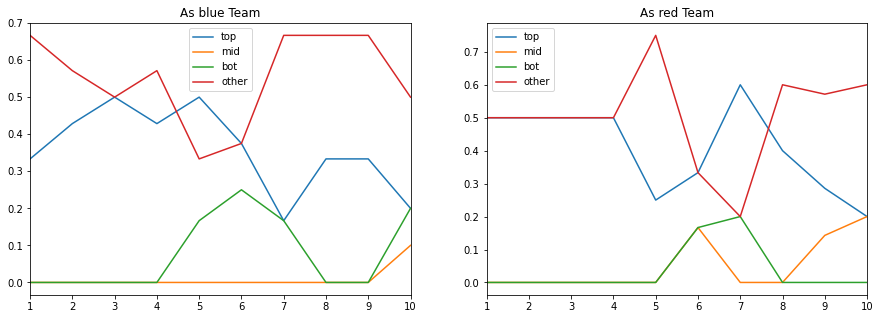

<Figure size 360x720 with 0 Axes>

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig = plt .figure(figsize=(5,10))
x_axis = range(1,11)

for idx, team in enumerate(['blue','red']):
    for lane in ['top','mid','bot','other']:
        axs[idx].plot(x_axis,[pts/total for pts, total in zip(pts_log[team][lane], pts_log[team]['total'])], label = lane)
    axs[idx].set_xlim([1,10])
    axs[idx].legend()
    axs[idx].set_title(f"As {team} Team")
plt.show()